# Description de la composition des clusters

- Calculer l'importance relative des variables
- Décrire chaque cluster (persona) par la moyenne et l'écart type de chaque variable à l'intérieur du cluster
- Pour chaque cluster afficher les variables les plus distinctives (par leur présence ou leur absence)

In [324]:
# Library
library(dplyr)
library(tidyr)
library(ggplot2)
library(ggtext)
library(tidytext)

# Load Data and Clustering Results
kmeans_result <- readRDS("../../_PrivateFolder_datagotchi_federal_2025/data/clustering/can2025/03_pilot_kmeans.rds") # nolint
df_pilot_2025 <- readRDS("../../_PrivateFolder_datagotchi_federal_2025/data/clustering/can2025/03_pilot_2025.rds")

In [325]:
getwd()

[1] "/Users/sarah-janevincent/Library/CloudStorage/Dropbox/clessn_capp/datagotchi/datagotchi_federal_2024/sjvin/cluster_baselineCan2025"

In [326]:
# Identifier les variables qui ont été utilisées pour la construction 
# des clusters à analyser
vars_clusters <- colnames(df_pilot_2025)[colnames(df_pilot_2025) %in% colnames(kmeans_result$centers)] # nolint: line_length_linter.

## Calcul de l'importance relative des variables utilisées pour le clustering

- Mesure l’importance relative des variables en comparant leurs moyennes par cluster à la moyenne globale.
- Utilise l’écart-type pour rendre les différences comparables entre variables.
- Normalise les scores pour les exprimer en proportions.

💡 Utilisation : Identifier quelles variables différencient le plus les clusters dans une segmentation.

In [327]:
# Fonction pour calculer l'importance relative de chaque variable 
# dans la création des clusters -----------------------------

# Fonction pour calculer l'importance relative des variables dans le clustering
calculate_importance <- function(data, variables) {
  importance_scores <- sapply(variables, function(var) {
    overall_mean <- mean(data[[var]], na.rm = TRUE)
    cluster_means <- tapply(data[[var]], data$cluster, mean, na.rm = TRUE)
    abs_diff <- abs(cluster_means - overall_mean) / sd(data[[var]], na.rm = TRUE)
    return(mean(abs_diff, na.rm = TRUE))
  })
  importance_scores <- importance_scores / sum(importance_scores)  # Normaliser
  return(importance_scores)
}

In [328]:
# Calcul du score d'importance relatif pour chaque variable
importance_scores <- calculate_importance(df_pilot_2025, vars_clusters)
importance_scores <- signif(importance_scores[order(desc(importance_scores))], 4)
cat(paste(names(importance_scores), ":", importance_scores, collapse = "\n"))

lifestyle_exerciseYoga : 0.08337
lifestyle_clothingStyleOther : 0.06949
ses_incomeMid : 0.06892
ses_incomeHigh : 0.05945
lifestyle_exerciseNone : 0.05533
ses_incomeLow : 0.05506
lifestyle_ownPetNone : 0.04927
lifestyle_ownPetDog : 0.04812
lifestyle_ownPetCat : 0.04756
ses_languageFrench : 0.03801
ses_regionQuebec : 0.03534
lifestyle_goHuntingFreq_numeric : 0.03431
lifestyle_exerciseGym : 0.03232
lifestyle_smokeFreq : 0.03042
ses_educUniv : 0.02806
ses_dwellingDetachedHouse : 0.0259
lifestyle_hasTattoos : 0.0257
ses_age : 0.02519
ses_immigrant : 0.02277
lifestyle_consCoffeeNone : 0.02096
ses_dwellingApp : 0.02027
lifestyle_typeTransportNoCar : 0.01906
ses_educBHS : 0.01851
lifestyle_consCoffeeTimHortons : 0.01441
lifestyle_favAlcoolWhiteWine : 0.01421
lifestyle_consClothesFrip : 0.01312
lifestyle_favAlcoolDontDrink : 0.01288
lifestyle_favAlcoolRedWine : 0.01234
lifestyle_eatMeatFreq : 0.01196
lifestyle_consCoffeeIndependent : 0.007655

## Décrire les personas

Calcule les moyennes et écarts-types de chaque variable par cluster

In [329]:
# Fonction pour décrire les personas en affichant les moyennes et écarts-types par cluster
# (La variable "cluster" doit déjà être présente et factorisée dans data)
describe_personas <- function(data, variables) {
  persona_summary <- data %>%
    group_by(cluster) %>%
    summarise(across(all_of(variables), list(X_mean = ~mean(.x, na.rm = TRUE),
                                               X_sd = ~sd(.x, na.rm = TRUE))))
  return(persona_summary)
}

In [330]:
# Afficher les statistiques descriptives par cluster
describe_personas(df_pilot_2025, vars_clusters)

cluster,lifestyle_exerciseGym_X_mean,lifestyle_exerciseGym_X_sd,lifestyle_exerciseYoga_X_mean,lifestyle_exerciseYoga_X_sd,lifestyle_exerciseNone_X_mean,lifestyle_exerciseNone_X_sd,lifestyle_goHuntingFreq_numeric_X_mean,lifestyle_goHuntingFreq_numeric_X_sd,lifestyle_clothingStyleOther_X_mean,...,ses_incomeLow_X_mean,ses_incomeLow_X_sd,ses_incomeMid_X_mean,ses_incomeMid_X_sd,ses_incomeHigh_X_mean,ses_incomeHigh_X_sd,ses_languageFrench_X_mean,ses_languageFrench_X_sd,ses_regionQuebec_X_mean,ses_regionQuebec_X_sd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00000000,0.0000000,1,0,0.00000000,0.0000000,0.11363636,0.2642067,0,...,0.04545455,0.2132007,0.5909091,0.5032363,0.36363636,0.4923660,0.272727273,0.4558423,0.31818182,0.47673129
2,0.14705882,0.3550358,0,0,0.00000000,0.0000000,0.02205882,0.1029308,0,...,0.00000000,0.0000000,1.0000000,0.0000000,0.00000000,0.0000000,0.004901961,0.0700140,0.03431373,0.18248158
3,0.00000000,0.0000000,0,0,1.00000000,0.0000000,0.06428571,0.2239537,0,...,0.14285714,0.3524537,0.8285714,0.3796042,0.02857143,0.1678015,0.442857143,0.5003105,0.45714286,0.50175675
4,0.14634146,0.3578390,0,0,0.12195122,0.3312946,0.10975610,0.2374920,1,...,0.24390244,0.4347694,0.6585366,0.4800915,0.09756098,0.3004062,0.390243902,0.4938648,0.39024390,0.49386480
5,0.14960630,0.3580977,0,0,0.00000000,0.0000000,0.05905512,0.1620084,0,...,0.00000000,0.0000000,1.0000000,0.0000000,0.00000000,0.0000000,0.362204724,0.4825411,0.41732283,0.49507006
6,0.06666667,0.2504897,0,0,0.00000000,0.0000000,0.03333333,0.1552084,0,...,0.00000000,0.0000000,1.0000000,0.0000000,0.00000000,0.0000000,0.958333333,0.2006642,0.99166667,0.09128709
7,0.66216216,0.4762015,0,0,0.00000000,0.0000000,0.61486486,0.3046140,0,...,0.05405405,0.2276679,0.8648649,0.3442015,0.08108108,0.2748228,0.094594595,0.2946518,0.17567568,0.38314160
8,0.24427481,0.4313058,0,0,0.06106870,0.2403755,0.09160305,0.2130504,0,...,0.00000000,0.0000000,0.0000000,0.0000000,1.00000000,0.0000000,0.229007634,0.4218072,0.25954198,0.44006619
9,0.11206897,0.3168198,0,0,0.00000000,0.0000000,0.09051724,0.1933586,0,...,0.00000000,0.0000000,1.0000000,0.0000000,0.00000000,0.0000000,0.172413793,0.3793785,0.18965517,0.39372895


## Identification des variables distinctives

Pour chaque cluster, identifier les variables qui le distingue des autres clusters.

1. Calculer les moyennes globlale et par cluster de chaque variable
1. Associer une couleur (rouge, vert, noir) à chaque variable de chaque cluster en fonction de la capacité de la variable à distinguer le cluster
1. Afficher sous forme de graphique la différence entre la moyenne du cluster et la moyenne globale pour chaque variable de chaque cluster. 

Dans les graphiques, les variables distinctives seront colorées en 

- rouge si leur moyenne dans le cluster est significativement sous la moyenne globale. On dira que leur absence caractérise le cluster.
- vert si leur moyenne est significativement au-dessus de la moyenne globale. On dira que leur présence caractérise le cluster.

In [331]:
# Produire une table contenant la valeur moyenne pour chaque
# variable (mean_overall) et la valeur moyenne par variable par
# cluster (mean_per_cluster)
df_means <- df_pilot_2025 %>%
  select(all_of(vars_clusters), cluster_name) %>%
  pivot_longer(cols = -cluster_name, names_to = "variable", values_to = "value") %>%
  group_by(variable) %>%
  mutate(mean_overall = mean(value, na.rm = TRUE)) %>%
  group_by(variable, cluster_name) %>%
  summarise(mean_per_cluster = mean(value, na.rm = TRUE), mean_overall = first(mean_overall), .groups = "drop")


In [332]:
# Fonction pour déterminer la couleur d'une variable binaire
#   Black : La variable ne distingue pas le cluster
#   Red : La variable distingue le cluster par son absence
#   Green : La variable distingue le cluster par sa présence
calculate_binary_color <- function(cluster_data, df, var) {
  prop_cluster <- mean(cluster_data[[var]], na.rm = TRUE)
  prop_overall <- mean(df[[var]], na.rm = TRUE)
  
  # Test de proportion
  p_value <- prop.test(
    x = c(sum(cluster_data[[var]]), sum(df[[var]])), 
    n = c(nrow(cluster_data), nrow(df))
  )$p.value
  
  # Calcul de la différence des proportions
  prop_diff <- abs(prop_cluster - prop_overall)
  
  # Déterminer la couleur selon les résultats du test
  if (p_value < 0.1 && prop_diff > 0.05) {
    return(ifelse(prop_cluster > prop_overall, "green", "red"))
  } else {
    return("black")
  }
}

In [333]:
# Fonction pour déterminer la couleur d'une variable continue
#   Black : La variable ne distingue pas le cluster
#   Red : La variable distingue le cluster par son absence
#   Green : La variable distingue le cluster par sa présence
calculate_continuous_color <- function(cluster_data, df, var) {
  # Test de Student
  t_test <- t.test(cluster_data[[var]], df[[var]])
  
  # Calcul de la taille d'effet (Cohen's d)
  effect_size <- abs(t_test$estimate[1] - t_test$estimate[2]) / sd(df[[var]], na.rm = TRUE)
  
  # Déterminer la couleur selon le p-value et la taille d'effet
  if (t_test$p.value < 0.1 && effect_size > 0.05) {
    return(ifelse(t_test$estimate[1] > t_test$estimate[2], "green", "red"))
  } else {
    return("black")
  }
}

In [334]:
# Pour chaque variable de chaque cluster, associer une couleur selon
# la capacité de la variable à caractériser un cluster
#   Black : La variable ne distingue pas le cluster
#   Red : La variable distingue le cluster par son absence
#   Green : La variable distingue le cluster par sa présence
dfUsedForClustering <- df_pilot_2025
variablesUsedForClustering <- vars_clusters

# Créer un dataframe vide pour stocker les résultats
df_colors <- data.frame(cluster_name = character(), variable = character(), color = character(), stringsAsFactors = FALSE)  #nolint

# Boucle pour traiter chaque cluster
for (cluster_value in unique(dfUsedForClustering$cluster_name)) {
  # Filtrer les données pour le cluster actuel
  cluster_data <- dfUsedForClustering %>% filter(cluster_name == cluster_value)

  # Identification des caractéristiques marquantes
  characteristic_vars <- sapply(variablesUsedForClustering, function(var) {
    if (all(dfUsedForClustering[[var]] %in% c(0, 1))) {
      # Si la variable est binaire, on utilise la fonction pour binaire
      return(calculate_binary_color(cluster_data, dfUsedForClustering, var))
    } else {
      # Si la variable est continue, on utilise la fonction pour continue
      return(calculate_continuous_color(cluster_data, dfUsedForClustering, var))
    }
  })

  # Ajouter les résultats pour ce cluster dans le tableau global
  cluster_results <- data.frame(
    cluster_name = rep(cluster_value, length(variablesUsedForClustering)),
    variable = variablesUsedForClustering,
    color = characteristic_vars,
    stringsAsFactors = FALSE
  )

  # Fusionner les résultats du cluster avec le dataframe global
  df_colors <- bind_rows(df_colors, cluster_results)
}
rownames(df_colors) <- NULL

Warning message in prop.test(x = c(sum(cluster_data[[var]]), sum(df[[var]])), n = c(nrow(cluster_data), :
"L'approximation du Chi-2 est peut-^etre incorrecte"
Warning message in prop.test(x = c(sum(cluster_data[[var]]), sum(df[[var]])), n = c(nrow(cluster_data), :
"L'approximation du Chi-2 est peut-^etre incorrecte"
Warning message in prop.test(x = c(sum(cluster_data[[var]]), sum(df[[var]])), n = c(nrow(cluster_data), :
"L'approximation du Chi-2 est peut-^etre incorrecte"
Warning message in prop.test(x = c(sum(cluster_data[[var]]), sum(df[[var]])), n = c(nrow(cluster_data), :
"L'approximation du Chi-2 est peut-^etre incorrecte"
Warning message in prop.test(x = c(sum(cluster_data[[var]]), sum(df[[var]])), n = c(nrow(cluster_data), :
"L'approximation du Chi-2 est peut-^etre incorrecte"
Warning message in prop.test(x = c(sum(cluster_data[[var]]), sum(df[[var]])), n = c(nrow(cluster_data), :
"L'approximation du Chi-2 est peut-^etre incorrecte"
Warning message in prop.test(x = c(sum(cluster

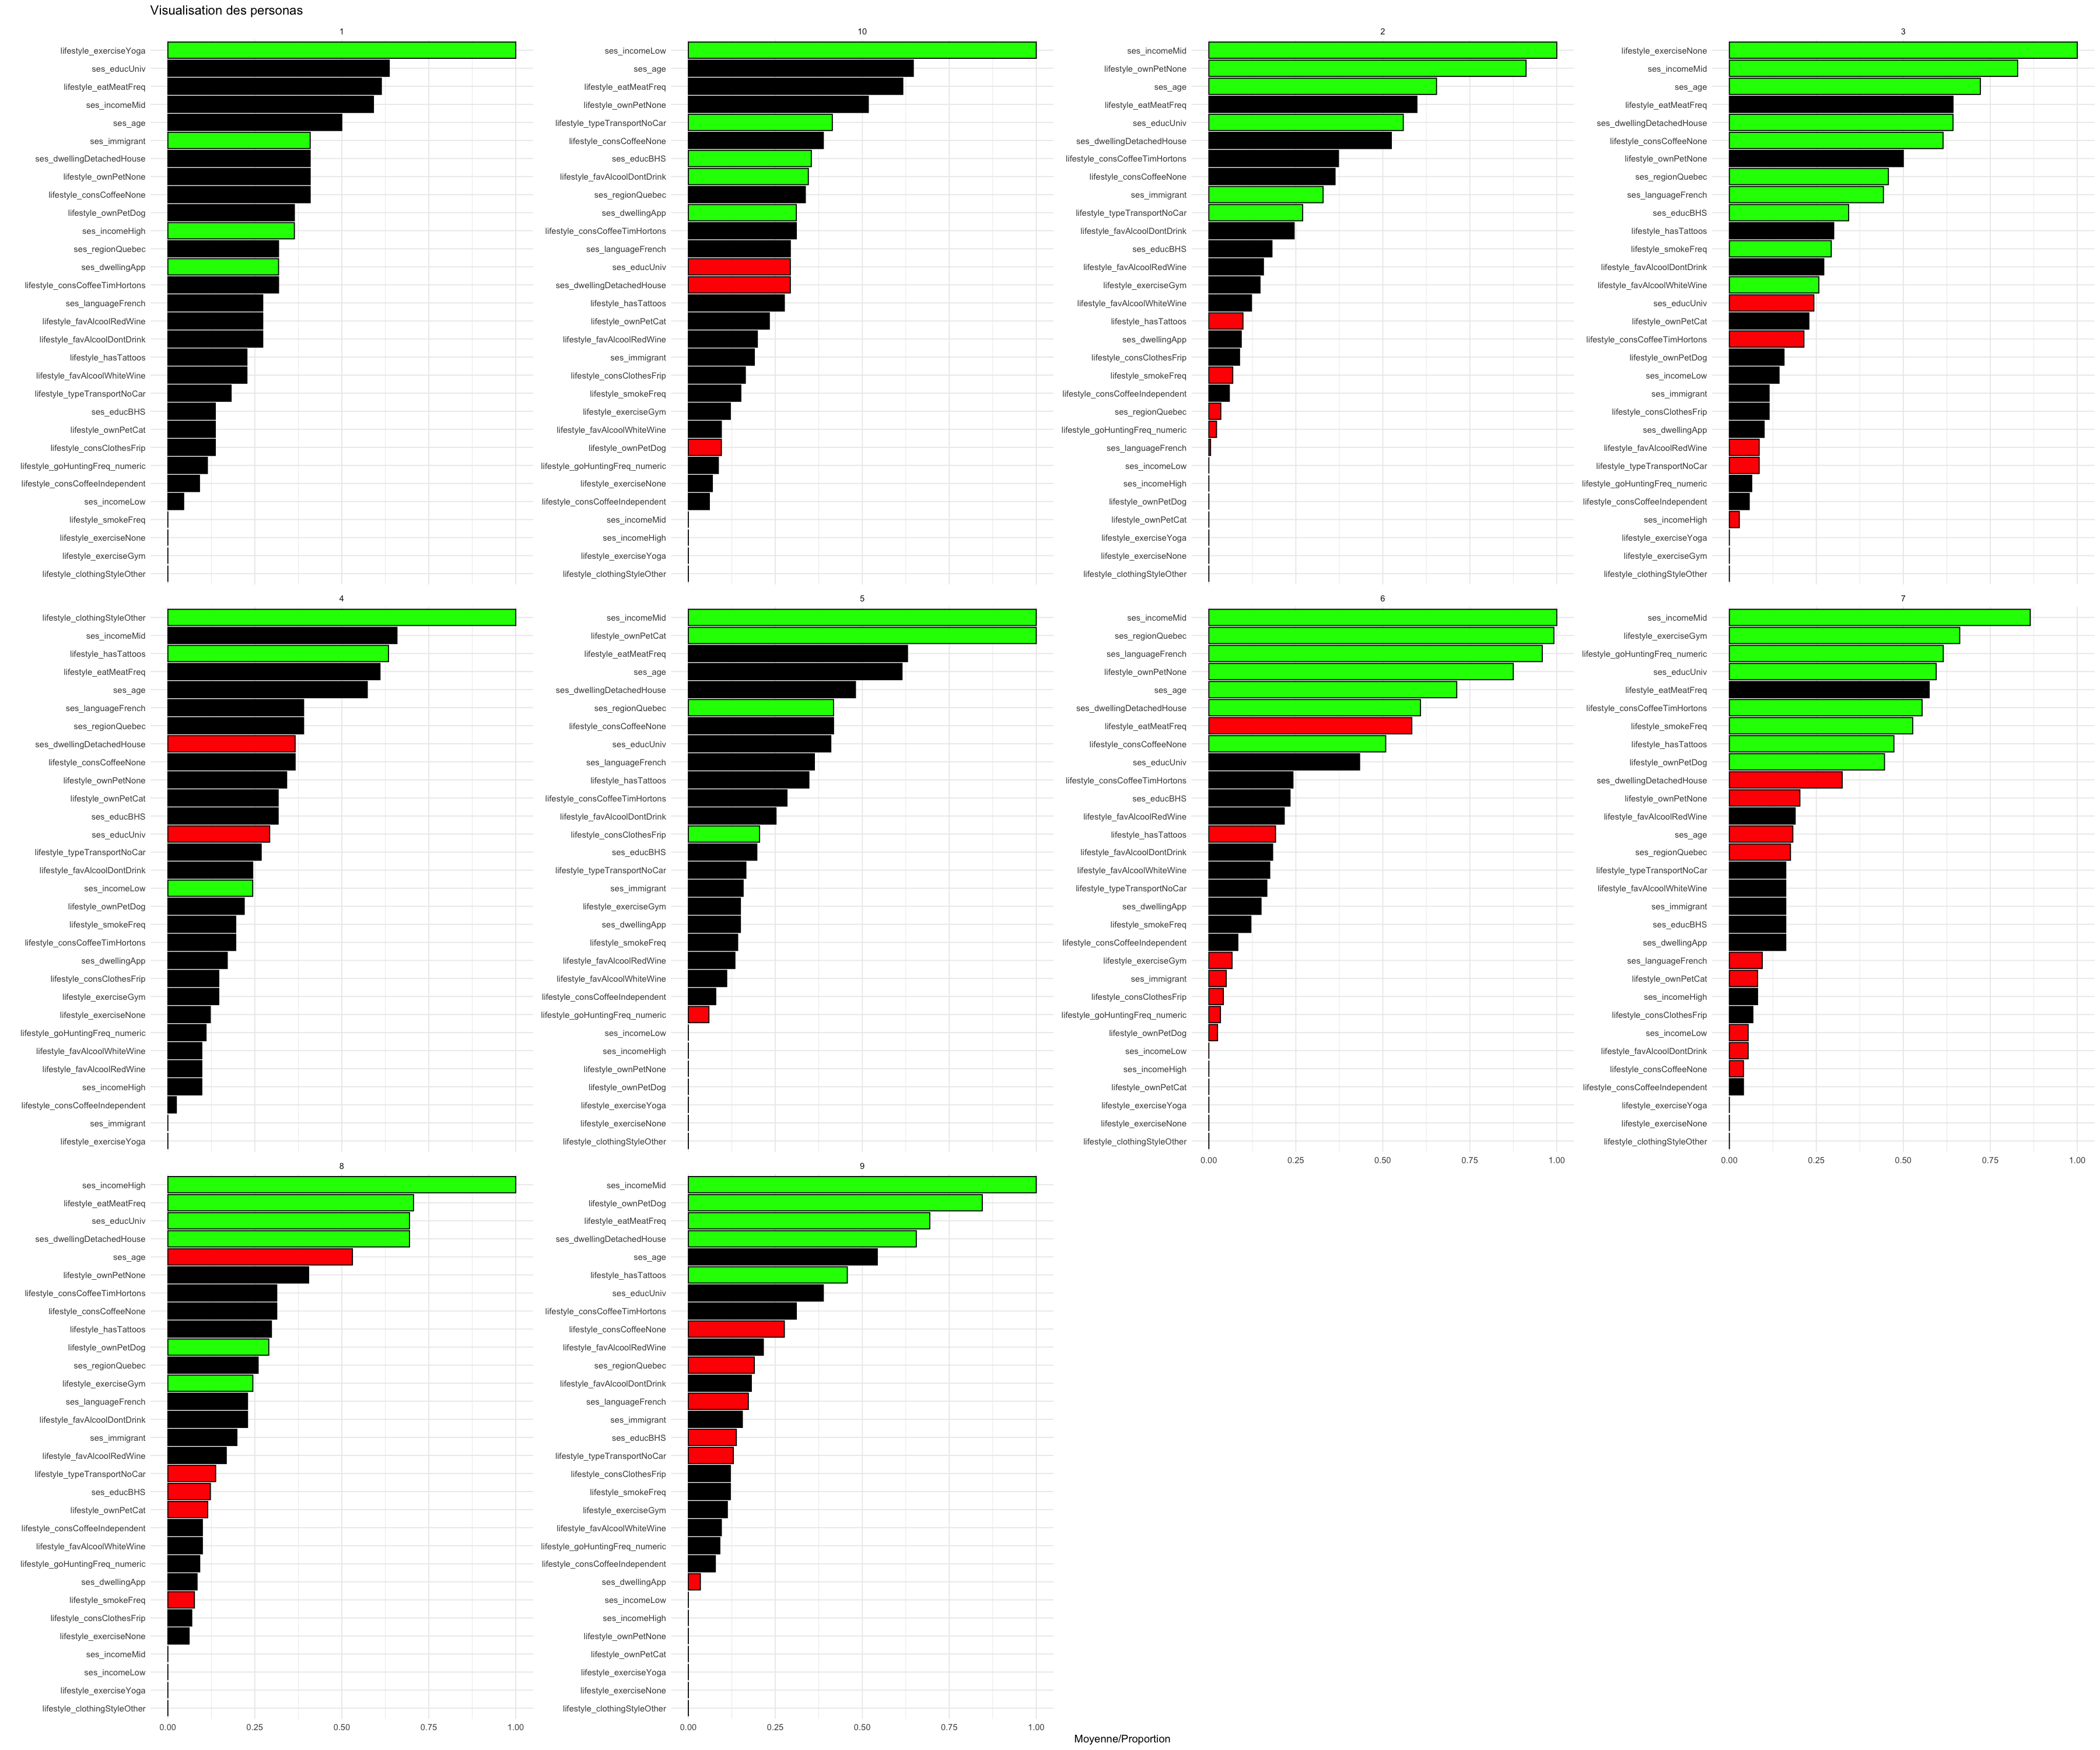

In [335]:
options(jupyter.plot_mimetypes = "image/png")
options(repr.plot.width = 30, repr.plot.height = 25)

df_joined <- df_means %>%
  left_join(df_colors, by = c("variable", "cluster_name"))

# Tri des données pour le graphique
all_data_viz <- df_joined %>%
  group_by(cluster_name) %>%
  arrange(desc(mean_per_cluster)) %>%
  ungroup() %>%
  mutate(cluster_name = as.factor(cluster_name),
         variable = as.character(variable))

# Afficher le graphique
ggplot(all_data_viz, aes(x = reorder_within(variable, mean_per_cluster, cluster_name), y = mean_per_cluster, fill = color)) +
  geom_bar(stat = "identity", color = "black", show.legend = FALSE) +
  scale_fill_identity() +
  labs(title = "Visualisation des personas", x = "", y = "Moyenne/Proportion") +
  theme_minimal() +
  coord_flip() +
  facet_wrap(~ cluster_name, scales = "free_y") +
  scale_x_reordered()

variable,cluster_name,mean_per_cluster,mean_overall,color
<chr>,<chr>,<dbl>,<dbl>,<chr>
lifestyle_exerciseYoga,1,1.000000000,0.02154750,green
ses_immigrant,1,0.409090909,0.18413320,green
ses_incomeHigh,1,0.363636364,0.14789422,green
ses_dwellingApp,1,0.318181818,0.13712047,green
lifestyle_exerciseGym,1,0.000000000,0.16748286,red
lifestyle_smokeFreq,1,0.000000000,0.15230167,red
ses_incomeLow,10,1.000000000,0.13809990,green
lifestyle_typeTransportNoCar,10,0.413793103,0.20568071,green
ses_educBHS,10,0.353448276,0.21057786,green


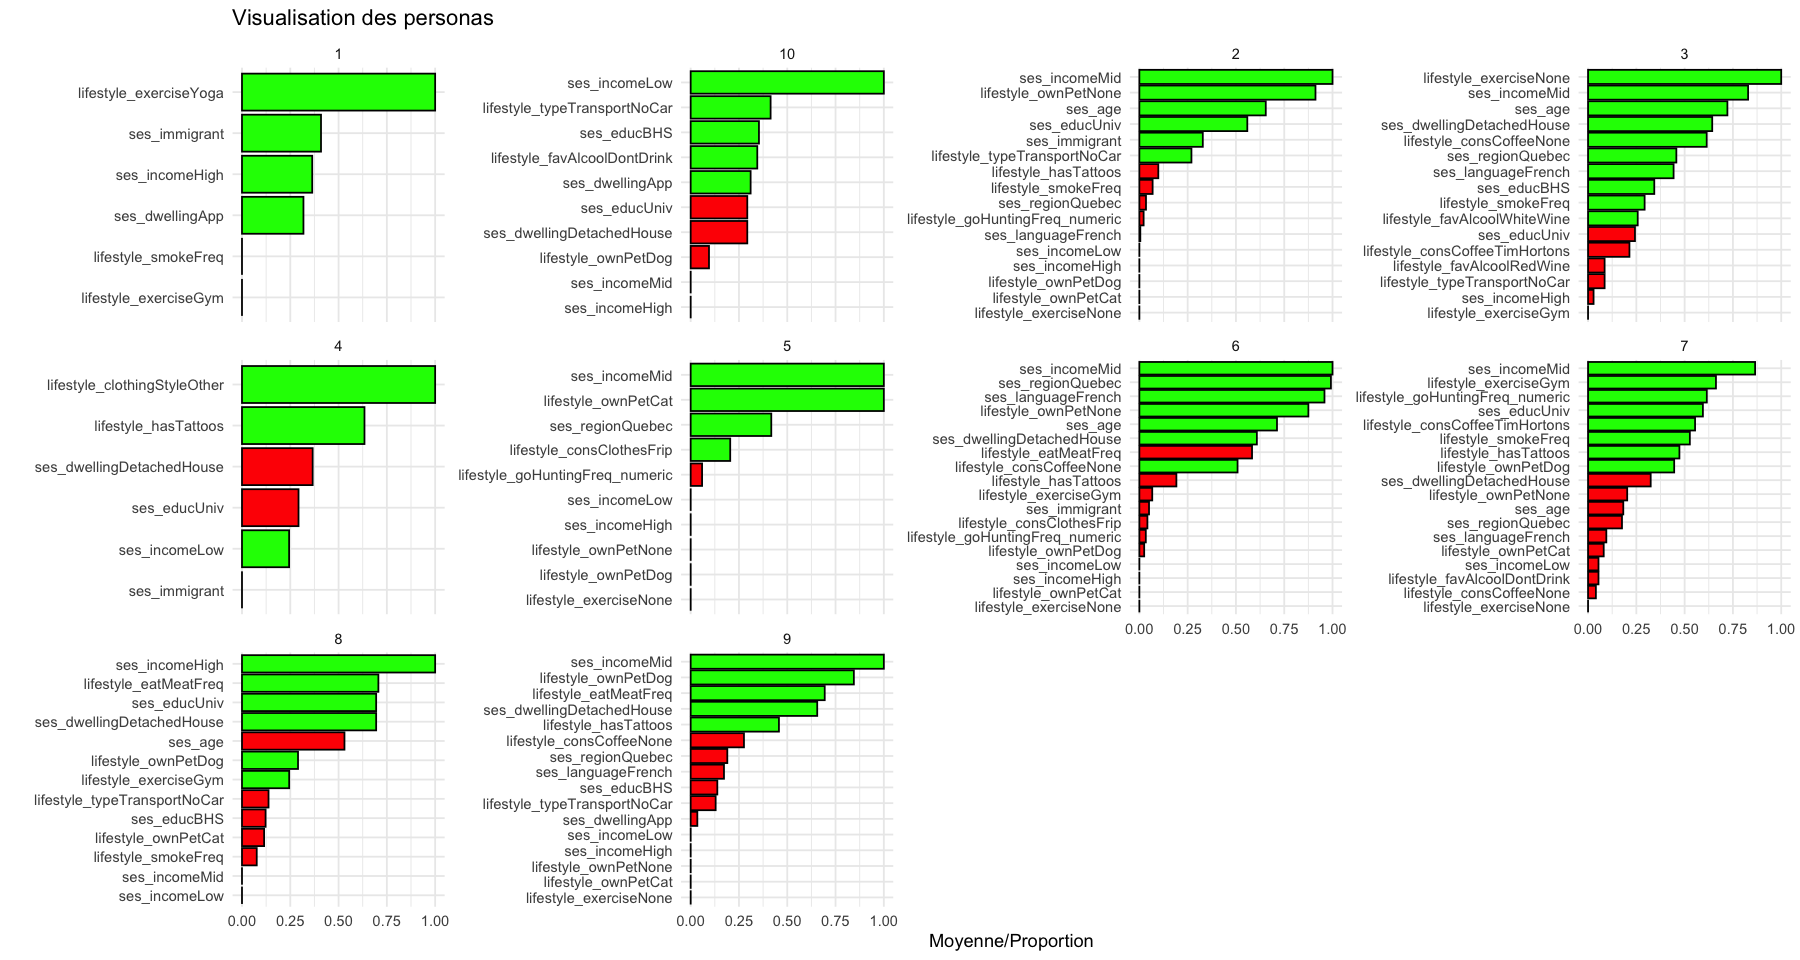

In [336]:
options(jupyter.plot_mimetypes = "image/png")
options(repr.plot.width = 15, repr.plot.height = 8)

# Afficher les variables distinctives par clusters
all_data_viz_signif <- all_data_viz %>%
  filter(color %in% c("green", "red"))

# Afficher le graphique
ggplot(all_data_viz_signif, aes(x = reorder_within(variable, mean_per_cluster, cluster_name), y = mean_per_cluster, fill = color)) +
  geom_bar(stat = "identity", color = "black", show.legend = FALSE) +
  scale_fill_identity() +
  labs(title = "Visualisation des personas", x = "", y = "Moyenne/Proportion") +
  theme_minimal() +
  coord_flip() +
  facet_wrap(~ cluster_name, scales = "free_y") +
  scale_x_reordered()

df_distinctives_vars <- df_joined[which(df_joined$color != "black"),]
df_distinctives_vars <- df_distinctives_vars[order(df_distinctives_vars$cluster_name, desc(df_distinctives_vars$mean_per_cluster)),]
df_distinctives_vars

In [337]:
# Sauvegarder la table des mesures qui permettent d'identifier les variables significatives par clusters
saveRDS(df_joined, file = "../../_PrivateFolder_datagotchi_federal_2025/data/clustering/can2025/03_pilot_clusters_composition.rds")